<div style="width: 100%; background-color: #ef7d22; text-align: center">
<br><br>

<h1 style="color: white; font-weight: bold;">
    Predict the prices of houses in Boston
</h1>


<br><br> 
</div>

![boston-housing](https://user-images.githubusercontent.com/7065401/112419797-ca68fe80-8d0a-11eb-8f18-03381a6a1de8.png)

<hr>

In [75]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from dtreeviz.trees import dtreeviz
import graphviz
from IPython.display import Image

from sklearn import datasets
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.preprocessing import LabelEncoder
import pydotplus
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor,plot_tree
import random

import warnings
warnings.filterwarnings('ignore')

# Step 1: Pull in your data

In [76]:
# Pull in your data
boston = datasets.load_boston()
X = boston.data
y = boston.target
X.shape

(506, 13)

In [77]:
features = [str(f) for f in boston.feature_names]
print(features)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


# Step 2: Split data into train and test data

In [78]:
# Split data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Step 3: Instantiate your machine learning class

In [79]:
# This is where you set hyperparameters for model tuning
# Create a hyperparameter distribution like we did in the lessons
depth_list = [d for d in range(2,10)] + [None]
params = {'max_depth': depth_list,
          'min_samples_leaf': range(2,10),
          'min_samples_split': range(2,10,2)}

# Instantiate a decision tree regressor using criterion='mse' and set a random state
dt = DecisionTreeRegressor(criterion='mse', random_state=42)

# Instantiate a RandomSearchCV instance
treecv = RandomizedSearchCV(dt, params, cv=6, random_state=42)

# Fit the random search instance on train data
treecv.fit(X_train, y_train)

# Save the hyperparameters to a dictionary
best_hps = treecv.best_params_
best_hps

{'min_samples_split': 4, 'min_samples_leaf': 7, 'max_depth': 7}

In [80]:
# Use the best hyperparameters to instantiate a new regressor instance
regressor = DecisionTreeRegressor(
    criterion='mse',
    random_state=42,
    min_samples_split=best_hps['min_samples_split'],
    min_samples_leaf=best_hps['min_samples_leaf'],
    max_depth=best_hps['max_depth'])

# Step 4: Fit the model on your training data

In [81]:
# Fit the classifier to the train data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=7, min_samples_split=4,
                      random_state=42)

# Step 5: Make predictions on the train and test data

In [82]:
# Now we need can test how well the model works on unseen data using the test set
# Predict on the train data
y_pred_train = regressor.predict(X_train)
# Predict on the test data
y_pred_test = regressor.predict(X_test)

# Step 6: Evaluate model performance

In [83]:
# Get the baseline accuracy - for continuous targets that means always predicting the training mean
# Look at the training mean
y_train.mean()

# Get the mean_absolute_error of predicting the mean
mean_absolute_error(y_train,[y_train.mean()]*len(y_train))

6.809283403587883

In [84]:
# Calculate training error
mean_absolute_error(y_train,y_pred_train)

2.165651190119012

In [85]:
# Calculate testing error
mean_absolute_error(y_test,y_pred_test)

2.8526070787792244

# Step 7: Cost-Complexity Pruning

In [86]:
# Get a list of alphas to test
path = regressor.cost_complexity_pruning_path(X_train,y_train)
# path has a ccp_alphas attribute and an impurities attribute
len(path.ccp_alphas)

31

In [87]:
# Get a list of models for each alpha
models = list()
for ccp_alphas in path.ccp_alphas:
    reg_temp = DecisionTreeRegressor(criterion='mse',
                                     random_state=42,
                                     ccp_alpha=ccp_alphas)
    reg_temp.fit(X_train, y_train)
    models.append(reg_temp)
len(models)

31

In [88]:
# We know we never want a tree with one node.  We will always remove this model which is the last tree/alpha
ccp_alphas = path.ccp_alphas[:-1]
models = models[:-1]

In [89]:
print(len(ccp_alphas),len(models))

30 30


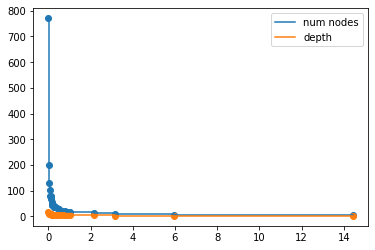

In [98]:
# Plot the number of nodes and depth for each model with the corresponding alpha
nodes_counts = [reg_temp.tree_.node_count for reg_temp in models]
depths = [reg_temp.tree_.max_depth for reg_temp in models]
plt.scatter(ccp_alphas,nodes_counts)
plt.scatter(ccp_alphas,depths)
plt.plot(ccp_alphas,nodes_counts,label='num nodes',drawstyle='steps-post')
plt.plot(ccp_alphas,depths,label='depth',drawstyle='steps-post')
plt.legend()
plt.show()

In [100]:
# Visualize our train and test accuracy with different values of alpha
# Get lists of training errors and testing errors
train_err = list()
test_err = list()
for reg_temp in models:
    y_pred_train = reg_temp.predict(X_train)
    y_pred_test = reg_temp.predict(X_test)
    train_err.append(mean_absolute_error(y_pred_train, y_train))
    test_err.append(mean_absolute_error(y_pred_test, y_test))

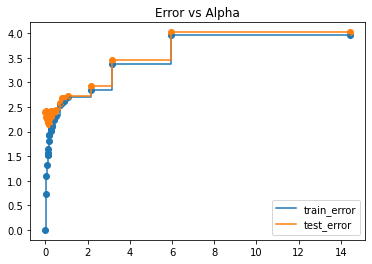

In [104]:
# Plot the errors with corresponding alphas
plt.scatter(ccp_alphas,train_err)
plt.scatter(ccp_alphas,test_err)
plt.plot(ccp_alphas,train_err,label='train_error',drawstyle='steps-post')
plt.plot(ccp_alphas,test_err,label='test_error',drawstyle='steps-post')
plt.legend()
plt.title('Error vs Alpha')
plt.show()

In [106]:
# Print the errors with the alphas - look for the lowest error and choose that alpha as the best
# You can do this visually or with a loop
import heapq
sorted = list()
for err, alph in zip(test_err, ccp_alphas):
    heapq.heappush(sorted,(err,alph))
best_alpha = heapq.heappop(sorted)[1]

In [ ]:
# Option for choosing the lowest with a loop


In [107]:
# Instantiate a new regressor with the best hyperparameters and the best alpha
regressor = DecisionTreeRegressor(criterion='mse',
                                  random_state=42,
                                  min_samples_split=best_hps['min_samples_split'],
                                  min_samples_leaf=best_hps['min_samples_leaf'],
                                  max_depth=best_hps['max_depth'],
                                  ccp_alpha=best_alpha)

In [108]:
# Fit the regressor to the train data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.1638218788984283, max_depth=7,
                      min_samples_leaf=7, min_samples_split=4, random_state=42)

In [109]:
# Predict on train and test to see new model scores
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

In [110]:
# New training error
mean_absolute_error(y_train,y_pred_train)

2.3969763151850176

In [111]:
# New testing error
mean_absolute_error(y_test,y_pred_test)

2.8273599933300657

## We have improved our testing error - the old score was ~2.85 and the new score is ~2.83

In [112]:
# Write out your model and data to use in the next project - Visualization
pickle.dump(regressor,open('data/reg_model.pkl','wb'))
pd.DataFrame(X_train).to_csv('data/boston_X_train.csv',index=False)
pd.DataFrame(y_train).to_csv('data/boston_y_train.csv',index=False)
with open('data/boston_features.txt','w') as f:
    feat_str = ','.join(features)
    print(feat_str)
    f.write(feat_str)

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
